In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd 
import numpy as np
from scipy.stats import trim_mean
from numpy import mean, absolute
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *
from sklearn import *

In [16]:
import pandas as pd
data_clust = pd.read_csv('/content/drive/MyDrive/UseLand_Clustering_Pron.csv' , sep = ";")

Text(0.5, 1.0, 'Colombia - Agricultural Land')

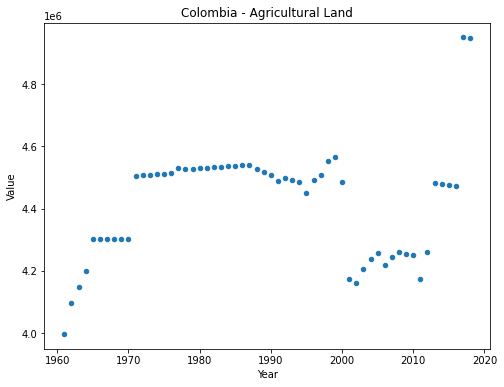

In [17]:
#data_clust = data_clust.drop(data_clust[data_clust['Value'] == 0].index)
data_clust.plot.scatter(x='Year',y='Value')
plt.title('Colombia - Agricultural Land')

In [18]:
data_clust.head()

,Year,Value
0,2018,4949200
1,2017,4949900
2,2016,4472300
3,2015,4475390
4,2014,4478470


In [19]:
from sklearn.cluster import KMeans
import numpy as np
# Definición de una funcion del simplekmeans para ver por iteraciones
from sklearn.metrics.pairwise import euclidean_distances
def simple_kmeans(data_clust,k, iter=100):
    # Inicializacion de los primeros centroides
    init_clus=np.random.choice(np.arange(data_clust.shape[0]),replace=False, size=k)
    #print(init_clus)
    clusters=data_clust[init_clus]
    preds=np.argmin(euclidean_distances(data_clust,clusters),axis=1)
    all_clusters=[clusters.copy()]
    all_preds=[preds]
    for i in range(iter):
        for clus in range(k):
            clusters[clus]=data_clust[preds==clus].mean(axis=0)
            all_clusters.append(clusters.copy())
            preds=np.argmin(euclidean_distances(data_clust,clusters),axis=1)
            all_preds.append(preds.copy())
    return all_clusters,all_preds

points = np.array(data_clust)
all_clusters,all_preds=simple_kmeans(points,17)


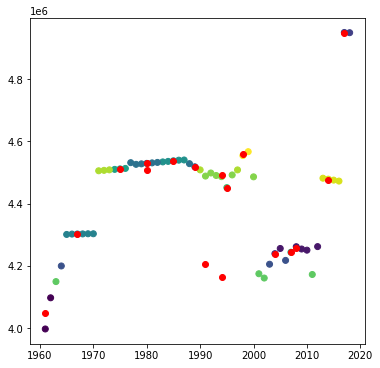

In [20]:
# Iteración 0. Se realiza la inicialización aleatoriamente, para el ejemplo son 5 puntos, 
# y los demas puntos se asignan al cluster más cercano.

iteration=80 #@param {type:"slider", min:0, max:80, step:1}
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],c=all_preds[iteration])
plt.scatter(all_clusters[iteration][:,0],all_clusters[iteration][:,1],c="r")

In [21]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# PRONÓSTICOS

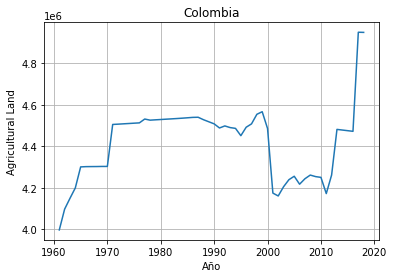

In [22]:
x = data_clust.Year
y = data_clust.Value
plt.figure(figsize = (6,4)) #Tamaño en x,y de la figura
plt . grid ( True )
plt.title('Colombia')
plt . ylabel('Agricultural Land')
plt . xlabel('Año')
plt . plot ( x, y )
plt.show()

In [61]:
data_clust.shape[0]

58

In [23]:
#VENTANA DE DATOS
#Divisió de los datos (70\%, 20\%, 10\%) para entrenmiento, validación y prueba, respectivamente.
column_indices = {name: i for i, name in enumerate(data_clust.columns)}
n =len(data_clust)
train_df = data_clust[0:int(n*0.7)]
val_df = data_clust[int(n*0.7):int(n*0.9)]
test_df = data_clust[int(n*0.9):]
num_features = data_clust.shape[1]

In [24]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [25]:
# Indices y compensaciones
w1 = WindowGenerator(input_width=5, label_width=1, shift=1,  # Cinco años de entrada,
                     label_columns=['Value'])
w1

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['Value']

In [26]:
# División

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [27]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]), np.array(train_df[:w1.total_window_size]), np.array(train_df[1:1+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 6, 2)
Inputs shape: (3, 5, 2)
labels shape: (3, 1, 1)


In [28]:
w1.example = example_inputs, example_labels

In [29]:
def plot(self, model=None, plot_col='Value', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [year]')

WindowGenerator.plot = plot

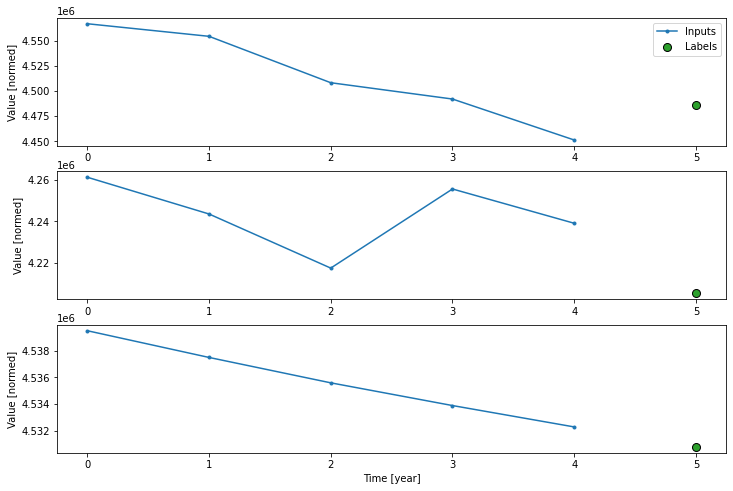

In [49]:
w1.plot(plot_col='Value')

In [50]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [51]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [52]:
w1.train.element_spec

(TensorSpec(shape=(None, 5, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [53]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 5, 2)
Labels shape (batch, time, features): (32, 1, 1)


In [54]:
# MODELOS DE UN SOLO PASO

single_step_window = WindowGenerator(
    input_width=5, label_width=1, shift=1,
    label_columns=['Value'])
single_step_window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['Value']

In [55]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 5, 2)
Labels shape (batch, time, features): (32, 1, 1)


In [56]:
#Modelo base
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [57]:
baseline = Baseline(label_index=column_indices['Value'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 136ms/step - loss: 16815090688.0000 - mean_absolute_error: 85191.4297


In [58]:
wide_window = WindowGenerator(
    input_width=5, label_width=5, shift=1,
    label_columns=['Value'])

wide_window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [1 2 3 4 5]
Label column name(s): ['Value']

In [59]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 5, 2)
Output shape: (32, 5, 1)


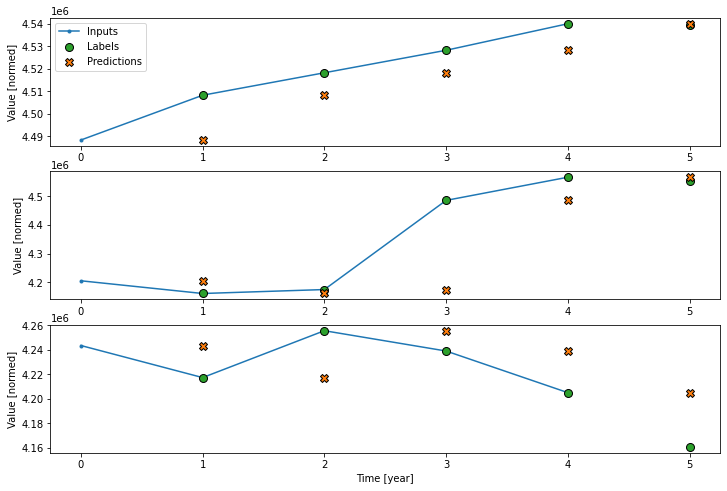

In [64]:
wide_window.plot(baseline)

In [66]:
### MODELO LINEAL

linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [67]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 5, 2)
Output shape: (32, 5, 1)


In [68]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [69]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
2/2 [==============================] - 1s 158ms/step - loss: 11693709066240.0000 - mean_absolute_error: 3417250.5000 - val_loss: 11366994804736.0000 - val_mean_absolute_error: 3370167.5000
Epoch 2/20
2/2 [==============================] - 0s 70ms/step - loss: 11633171628032.0000 - mean_absolute_error: 3408405.2500 - val_loss: 11306685956096.0000 - val_mean_absolute_error: 3361208.7500
Epoch 3/20
2/2 [==============================] - 0s 61ms/step - loss: 11573119680512.0000 - mean_absolute_error: 3399568.7500 - val_loss: 11246573191168.0000 - val_mean_absolute_error: 3352256.0000
Epoch 4/20
2/2 [==============================] - 0s 65ms/step - loss: 11512834949120.0000 - mean_absolute_error: 3390710.7500 - val_loss: 11186610372608.0000 - val_mean_absolute_error: 3343301.5000
Epoch 5/20
2/2 [==============================] - 0s 63ms/step - loss: 11452915122176.0000 - mean_absolute_error: 3381869.0000 - val_loss: 11126714662912.0000 - val_mean_absolute_error: 3334333.0000
Epoc

In [70]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 5, 2)
Output shape: (32, 5, 1)


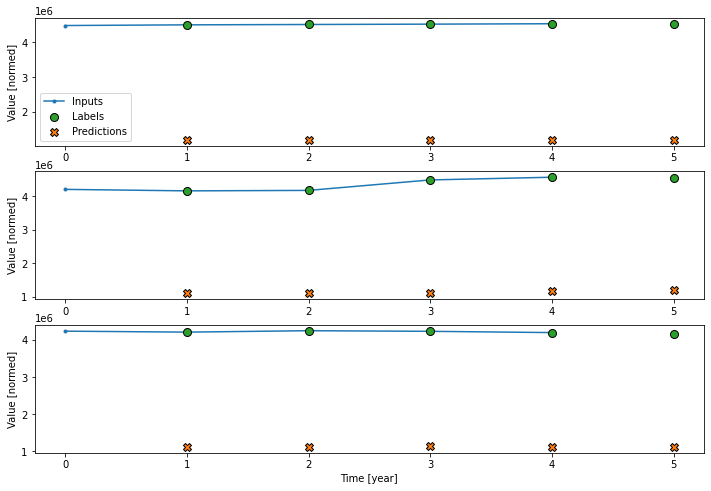

In [71]:
wide_window.plot(linear)